In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 1. Shifted picture WITH parallelization

In [1]:
%%writefile Nazarova_Shifted_pictures.py

import cv2
import numpy as np
from numba import jit
from mpi4py import MPI
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Initialization for parallelization
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

# Loag image
money_heist = cv2.imread('meme.jpg')
money_heist = cv2.cvtColor(money_heist, cv2.COLOR_BGR2RGB)

m = money_heist.shape[0]
n = money_heist.shape[1]

# I share which piece of the picture goes to which rank. 
#I can use the "Send" command here, but I think it will take longer. 
#I already know to which rank which piece will go
distr = n//(size)
list_of_distr = list(range(0, n+1, distr))
if list_of_distr[-1] != n:
    list_of_distr[-1] = n
    
list_to_send = []
for i in range(len(list_of_distr)-1):
    list_to_send.append([list_of_distr[i],list_of_distr[i+1]])
    
list_to_send = list_to_send[rank]


money_heist_split = money_heist[:, list_to_send[0]:list_to_send[1], :]

## Using Numpy
list_for_gif = []
for i in range(m):
    money_heist_split = np.roll(money_heist_split, 1, axis=0)

comm.Barrier()
Shifted = comm.gather(money_heist_split.copy(), root=0)

if rank == 0:
    Data = np.concatenate((Shifted[0], Shifted[1]), axis=1)
    
    for i in range(2,size):
        Data = np.concatenate((Data, Shifted[i]), axis=1)
        
    list_for_gif.append(Data)

## Algorithm with two loops

# for j in range(money_heist_split.shape[0]):
#     current = money_heist_split[0, :, :]
#     for i in range(money_heist_split.shape[0]):
#         try:
#             next_ = money_heist_split[i+1, :, :].copy()

#             money_heist_split[i+1, :, :] = current

#             current = next_

#         except:
#             money_heist_split[0, :, :] = current
            
    # comm.Barrier()
    # Shifted = comm.gather(money_heist_split.copy(), root=0)

    # if rank == 0:
    #     Data = np.concatenate((Shifted[0], Shifted[1]), axis=1)
        
    #     for i in range(2,size):
    #         Data = np.concatenate((Data, Shifted[i]), axis=1)
            
    #     list_for_gif.append(Data)

Overwriting Nazarova_Shifted_pictures.py


In [ ]:
# %timeit !mpirun --allow-run-as-root -np 6 python3 Nazarova_Shifted_pictures.py

1 loop, best of 5: 29 s per loop


In [ ]:
# !pip install mpi4py

# 2. Plot the speedup vs number of processors

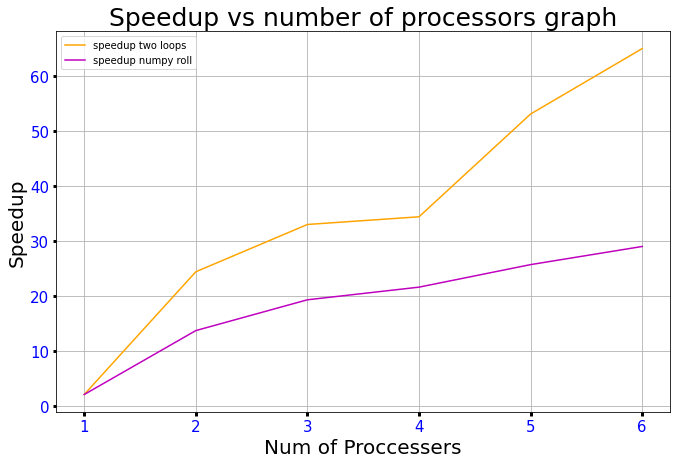

In [ ]:
n_of_processors = [1, 2, 3, 4, 5, 6]
speedup_two_loops = [2.07, 24.4, 33, 34.4, 53.1, 65]
speedup_numpy_roll = [2.07, 13.7, 19.3, 21.6, 25.7, 29]

plt.figure(figsize=(11,7))
plt.plot(n_of_processors, speedup_two_loops, c='orange', label='speedup two loops')
plt.plot(n_of_processors, speedup_numpy_roll, c='m', label='speedup numpy roll')
plt.ylabel('Speedup',fontsize=20)
plt.xlabel('Num of Proccessers', fontsize=20)
plt.tick_params(labelcolor='b', labelsize=15, width=3)
plt.title('Speedup vs number of processors graph',fontsize=25)
plt.legend()
plt.grid()
plt.show()

When we parallelize the speedup it gets worse. It seems to me that this is due to the fact that my step is too small. I always shift by 1 pixel, although I can shift by 5 or 10. Because of this, I have to send "gather" many times and it wastes a lot of time. I also use "Barrier" just in case to make the gif look exactly right.

For the sake of interest, I did it through numpy and through magnifiers. It is clear that through numpy it is faster

# 3. Plot memory consumption vs number of processors

In [2]:
%%writefile Nazarova_Shifted_pictures_memory.py

import cv2
import numpy as np
from numba import jit
from mpi4py import MPI
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import datetime
import resource
import os

# Initialization for parallelization
mem = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

fname = 'r{}.log'.format(rank)
with open(fname, 'a') as f:
    # Dump timestamp, PID and amount of RAM.
    f.write('{}\n'.format(mem))

start = MPI.Wtime()

# Loag image
money_heist = cv2.imread('meme.jpg')
money_heist = cv2.cvtColor(money_heist, cv2.COLOR_BGR2RGB)

m = money_heist.shape[0]
n = money_heist.shape[1]

# I share which piece of the picture goes to which rank. 
#I can use the "Send" command here, but I think it will take longer. 
#I already know to which rank which piece will go
distr = n//(size)
list_of_distr = list(range(0, n+1, distr))
if list_of_distr[-1] != n:
    list_of_distr[-1] = n
    
list_to_send = []
for i in range(len(list_of_distr)-1):
    list_to_send.append([list_of_distr[i],list_of_distr[i+1]])
    
list_to_send = list_to_send[rank]


money_heist_split = money_heist[:, list_to_send[0]:list_to_send[1], :]

## Using Numpy
list_for_gif = []
for i in range(m):
    money_heist_split = np.roll(money_heist_split, 1, axis=0)

comm.Barrier()
Shifted = comm.gather(money_heist_split.copy(), root=0)

if rank == 0:
    Data = np.concatenate((Shifted[0], Shifted[1]), axis=1)
    
    for i in range(2,size):
        Data = np.concatenate((Data, Shifted[i]), axis=1)
        
    list_for_gif.append(Data)

    end = MPI.Wtime()
    print(float(end - start))

Writing Nazarova_Shifted_pictures_memory.py


In [ ]:
# !mpirun --allow-run-as-root -np 2 python3 Nazarova_Shifted_pictures_memory.py

In [ ]:
# !ls

In [ ]:
memory = []
processors = np.arange(2,10)

for process in processors:
    !mpirun --allow-run-as-root -n {process} python3 Nazarova_Shifted_pictures_memory.py
    for i in range(process):
      !cat 'r{i}.log' >> 'memory{process}.txt'
    !rm *.log

0.6404311940000298
0.8290907109999353
0.7732323100001395
0.9009456819999286
0.8827394110001023
0.9739051039998685
1.1430529549998028
1.3679216460000134


In [ ]:
# !ls

meme.jpg     memory4.txt  memory7.txt  Nazarova_Shifted_pictures_memory.py
memory2.txt  memory5.txt  memory8.txt  sample_data
memory3.txt  memory6.txt  memory9.txt


In [ ]:
# !cat memory5.txt

168536
168668
169392
169200
169372


In [ ]:
memory = {}
for i in range(2,10):
    mem_name = f"memory{i}.txt"
    my_file = open(mem_name, "r")
    m = my_file. read()
    m = m.split("\n")
    m.pop()

    memory[f'{i}'] = m

In [ ]:
processes = list(memory.keys())
processes = np.array(processes, dtype='int')
mem = list(memory.values())

for i in range(len(mem)):
    mem[i] = sum([int(m) for m in mem[i]]) 

mem = np.array(mem)
memory_data = mem/10e6 

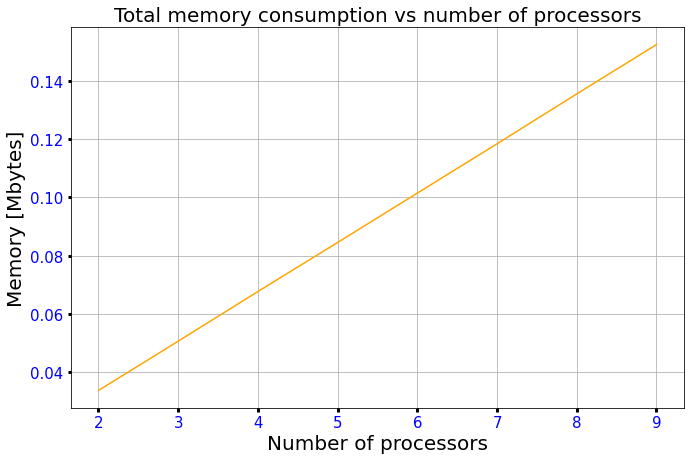

In [ ]:
plt.figure(figsize=(11,7))
plt.plot(processes,memory_data, color='orange')

plt.title('Total memory consumption vs number of processors',fontsize=20)
plt.xlabel('Number of processors',fontsize=20)
plt.ylabel('Memory [Mbytes]',fontsize=20)
plt.tick_params(labelcolor='b', labelsize=15, width=3)
plt.grid()
plt.show()

# 4. WITHOUT parallelization

In [ ]:
# %%timeit

meme = cv2.imread('meme.jpg')
meme = cv2.cvtColor(meme, cv2.COLOR_BGR2RGB)

# print(meme.shape)

# plt.imshow(meme)
# plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
# plt.show()

list_to_gif = []
# for j in range(meme.shape[0]):
#     current = meme[0, :, :]
#     for i in range(meme.shape[0]):
#         try:
#             next_ = meme[i+1, :, :].copy()

#             meme[i+1, :, :] = current

#             current = next_

#         except:
#             meme[0, :, :] = current
            
#     list_to_gif.append(meme.copy()) 
#     image = plt.imshow(meme)
#     plt.show()

## 4.1.Just gif saving 

In [ ]:
# def save_gif(list_of_img):
    
#     gif = list_of_img

#     fig = plt.figure(figsize=(10, 8))
#     camera = Camera(fig)
#     ax = fig.add_subplot(1,1,1)

#     n = np.linspace(0, 1, 100)

#     for i in range(len(gif)):


#         ax.imshow(gif[i])

#         camera.snap()


#     animation = camera.animate()
#     animation.save('Meme.gif', writer = 'pillow', fps = 10)
#     print("You saved the gif")

You saved the gif


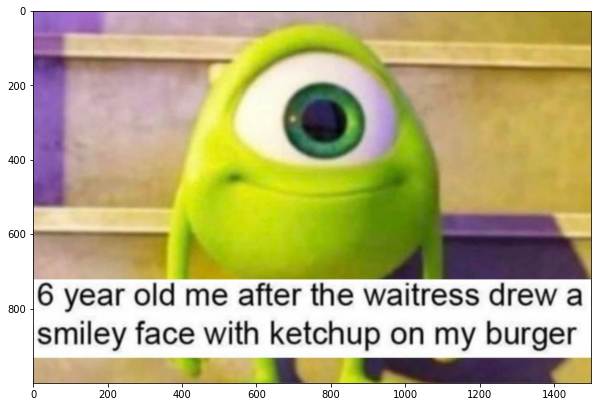

In [ ]:
save_gif(list_to_gif)